<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/Variable_Selection/Preselecting_variables_vs_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # R-style formula api

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
np.random.seed(1)

In [2]:
#Secret data generation!!
def secret_data(N):
  X_1 = np.random.randn(N)
  a = 0.95
  X_2 = a*X_1 + np.sqrt(1-a**2)*np.random.randn(N)
  X_3 = a*X_2 + np.sqrt(1-a**2)*np.random.randn(N)
  X_4 = a*X_3 + np.sqrt(1-a**2)*np.random.randn(N)
  X_5 = a*X_4 + np.sqrt(1-a**2)*np.random.randn(N)

  b = 2
  ep = 5
  Y_1 = b*X_1 + ep*np.random.randn(N)
  Y_2 = b*(X_2+X_3+X_4+X_5)/np.sqrt(4) + ep*np.random.randn(N)
  return X_1,X_2,X_3,X_4,X_5,Y_1,Y_2

N = 100
X_1,X_2,X_3,X_4,X_5,Y_1,Y_2 = secret_data(N)

#Multiple Linear Regression

In [3]:
df = pd.DataFrame({'X_1':X_1,'X_2':X_2,'X_3':X_3,'X_4':X_4, 'X_5':X_5, 'Y_1':Y_1, 'Y_2':Y_2})
df.head()

,X_1,X_2,X_3,X_4,X_5,Y_1,Y_2
0,1.624345,1.403512,1.208162,1.792795,1.295190,-5.348282,0.334838
1,-0.611756,-0.198816,0.068420,-0.394369,-0.350801,-0.937908,1.600227
2,-0.528172,-0.375773,-0.532564,-0.765157,-0.612231,-5.054081,-7.046036
3,-1.072969,-0.833975,-0.181866,-0.447733,-0.040374,-3.603910,-4.094676
4,0.865408,0.480251,0.040337,-0.048828,-0.178424,0.435901,-7.013682


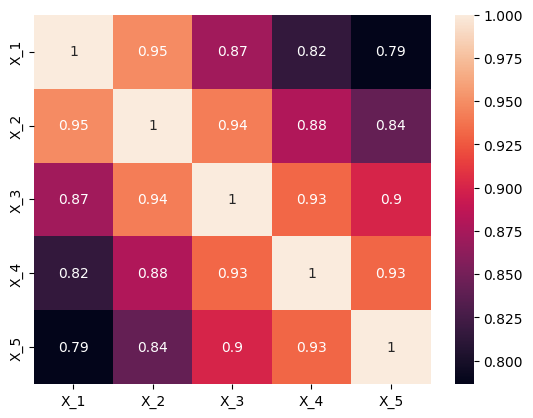

In [4]:
corr_matrix = df[['X_1', 'X_2','X_3','X_4','X_5']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Pre-selecting variables based on correlation (or any other criteria)


In [5]:
#If you delete all variables correlated with >0.7, then you end up with only X_1
# ols model with intercept

def single_var_regression(my_X,my_Y):
  my_test_size = 0.2
  df_train, df_test = train_test_split(df, test_size=my_test_size)

  Y_vs_X_model = smf.ols(formula= my_Y + ' ~ ' + my_X, data=df_train)

  #_ fitted model and summary
  Y_vs_X_fit = Y_vs_X_model.fit()
  print(f"Train set size = {int((1-my_test_size)*N)}")
  print(f"Test set size = {int(my_test_size*N)}")


  test_preds = Y_vs_X_fit.predict(df_test)
  MSE = np.mean( (df_test[my_Y] - test_preds)**2 )
  print(f"Test validation RMSE = { np.sqrt(MSE) }")


  #print(Y_vs_X_fit.summary())

  ## Plot it
  X1_axis = np.linspace(-4,4,100)
  Y1_pred = Y_vs_X_fit.predict(pd.DataFrame({my_X:X1_axis}))
  plt.plot(df_train[my_X],df_train[my_Y],'o',label='Train data')
  plt.plot(df_test[my_X],df_test[my_Y],'o',label='Test data')
  plt.plot(X1_axis,Y1_pred,'-',label=f'Lin. fit RMSE={np.sqrt(MSE):.3f}')
  plt.title(f"Single Variable Regression: {my_Y} vs {my_X}")
  plt.xlabel(my_X)
  plt.ylabel(my_Y)
  plt.legend()


## Y_1 vs X_1

Train set size = 80
Test set size = 20
Test validation RMSE = 7.066057831818544


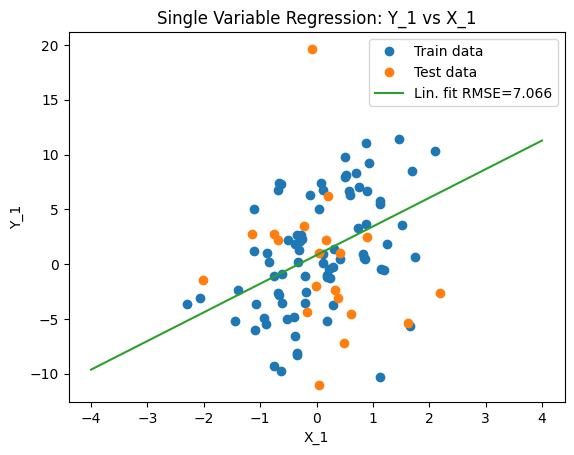

In [6]:
single_var_regression(my_X = 'X_1',my_Y = 'Y_1')

## Y_2 vs X_1

Train set size = 80
Test set size = 20
Test validation RMSE = 5.948012436333241


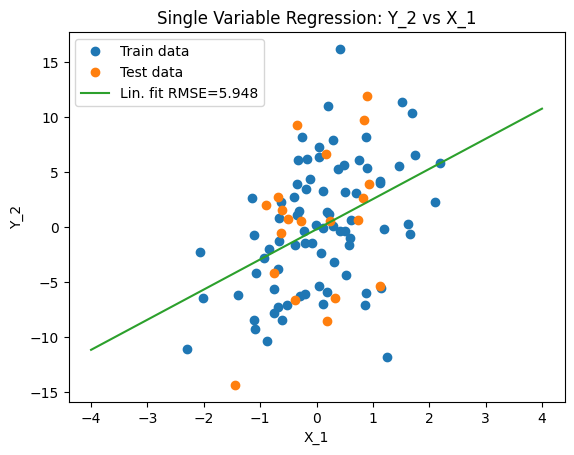

In [7]:
single_var_regression(my_X = 'X_1',my_Y = 'Y_2')

# Forward variable selection

In [8]:

def forward_subset_selection(X,y,my_test_size=0.5):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=my_test_size, random_state=3)

  def processSubset(feature_set, X_train, y_train, X_test, y_test):
      # Fit model on feature_set and calculate RSS
      model = sm.OLS(y_train,X_train[list(feature_set)])
      regr = model.fit()
      RMSE = np.sqrt( np.mean((regr.predict(X_test[list(feature_set)]) - y_test) ** 2) )
      return {'features':feature_set, 'model':regr, 'RMSE':RMSE}

  def forward(predictors, X_train, y_train, X_test, y_test):

      # Pull out predictors we still need to process
      remaining_predictors = [p for p in X_train.columns if p not in predictors]

      results = []

      for p in remaining_predictors:
          results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))

      # Wrap everything up in a nice dataframe
      models = pd.DataFrame(results)
      print("----Models tried in this round----\n", models[['features','RMSE']] )

      # Choose the model with the minimum RMSE
      best_model = models.loc[models['RMSE'].astype(float).idxmin()]

      # Return the best model, along with some other useful information about the model
      return best_model

  models_train = pd.DataFrame(columns=['RMSE', 'model'])

  predictors = []

  for i in range(1,len(X.columns)+1):
      models_train.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
      predictors = models_train.loc[i]['model'].model.exog_names

  plt.plot(models_train['RMSE'],'ob')
  plt.xlabel('# Predictors')
  plt.ylabel('Test RMSE')

  best_n_vars = models_train['RMSE'].astype(float).idxmin()
  best_RMSE = models_train['RMSE'].min()
  #Note: the plus 1 accounts for starting at 0 vs at 1 in the indexing
  plt.plot(best_n_vars, best_RMSE, 'or');
  plt.title(f"Best #Vars = {best_n_vars}")
  print("==========")
  print(f"Best number of vars found: {best_n_vars}")
  print(f"Best model found: {models_train.loc[best_n_vars]['model'].model.exog_names}")

#Y_1 subset selection

----Models tried in this round----
   features      RMSE
0    [X_1]  5.268800
1    [X_2]  5.231509
2    [X_3]  5.159531
3    [X_4]  5.166912
4    [X_5]  5.083194
----Models tried in this round----
      features      RMSE
0  [X_5, X_1]  5.146236
1  [X_5, X_2]  5.099634
2  [X_5, X_3]  5.087422
3  [X_5, X_4]  5.110337
----Models tried in this round----
           features      RMSE
0  [X_5, X_3, X_1]  5.141329
1  [X_5, X_3, X_2]  5.130547
2  [X_5, X_3, X_4]  5.134870
----Models tried in this round----
                features      RMSE
0  [X_5, X_3, X_2, X_1]  5.134568
1  [X_5, X_3, X_2, X_4]  5.170186
----Models tried in this round----
                     features      RMSE
0  [X_5, X_3, X_2, X_1, X_4]  5.171483
Best number of vars found: 1
Best model found: ['X_5']


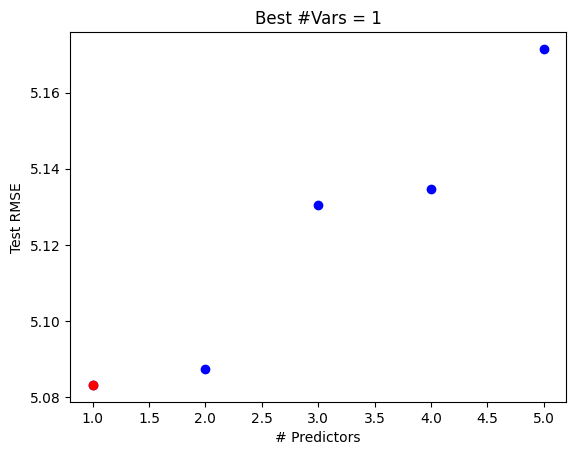

In [9]:
X = df.iloc[:, 0:5] #X_1 to X_5
Y_1 = df.iloc[:, 5] #Y_1
forward_subset_selection(X,Y_1)

# Y_2 Selection

----Models tried in this round----
   features      RMSE
0    [X_1]  5.487439
1    [X_2]  5.237467
2    [X_3]  4.909054
3    [X_4]  5.012898
4    [X_5]  4.783013
----Models tried in this round----
      features      RMSE
0  [X_5, X_1]  4.816796
1  [X_5, X_2]  4.794703
2  [X_5, X_3]  4.758987
3  [X_5, X_4]  4.798713
----Models tried in this round----
           features      RMSE
0  [X_5, X_3, X_1]  4.703049
1  [X_5, X_3, X_2]  4.709271
2  [X_5, X_3, X_4]  4.738195
----Models tried in this round----
                features      RMSE
0  [X_5, X_3, X_1, X_2]  4.732889
1  [X_5, X_3, X_1, X_4]  4.680146
----Models tried in this round----
                     features      RMSE
0  [X_5, X_3, X_1, X_4, X_2]  4.710764
Best number of vars found: 4
Best model found: ['X_5', 'X_3', 'X_1', 'X_4']


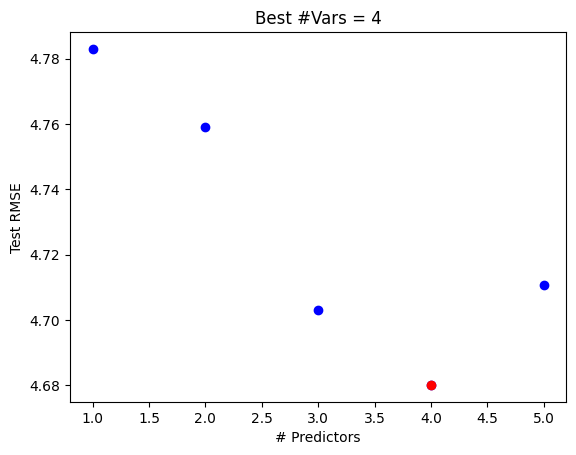

In [10]:
X = df.iloc[:, 0:5] #X_1 to X_5
Y_2 = df.iloc[:, 6] #Y_2
forward_subset_selection(X,Y_2)

# Using L^2 Regularization (aka "Ridge Regression")

In [11]:
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression

def try_many_ridge_reg(my_X,my_Y):

  X_train, X_test, y_train, y_test = train_test_split(my_X, my_Y, test_size=0.2, random_state=1)

  grid = 10 ** np.linspace(3,-2,100)

  ridge_model = Ridge() #normalize=True)
  coefs = []
  test_RMSE = []
  train_RMSE = []

  for a in grid:
    ridge_model.set_params(alpha=a)
    ridge_model.fit(X_train, y_train)
    coefs.append(ridge_model.coef_)


    preds = ridge_model.predict(X_test)
    test_RMSE.append( np.sqrt(np.mean( (preds - y_test)**2.0 ) ))

    preds = ridge_model.predict(X_train)
    train_RMSE.append( np.sqrt(np.mean( (preds - y_train)**2.0 ) ))


  best_alpha = grid[np.argmin(test_RMSE)]
  ax = plt.gca()
  ax.plot(grid, coefs)
  ax.set_xscale('log')

  ax.legend(my_X.columns)


  ax.axvline(best_alpha,label='Best Alpha',linestyle='--',color='k')
  plt.title("Coefficients vs Regularization Parameter")
  plt.axis('tight')
  plt.xlabel('ridge regularization parameter')
  plt.ylabel('weights')
  plt.show()

  ax = plt.gca()
  ax.plot(grid,test_RMSE,label="Test RMSE")
  ax.plot(grid,train_RMSE,label="Train RMSE")
  coeff_rms_size = np.sqrt( np.power(coefs,2).sum(axis=1) )
  ax.plot(grid,coeff_rms_size,label="Coefficients RMS")
  ax.axvline(best_alpha,label='Best Alpha (by Test RMSE)',linestyle='--',color='k')
  plt.xlabel('ridge regularization parameter')

  plt.title("Sizes of errors and coefficients")
  plt.ylabel('Sizes of things')

  ax.set_xscale('log')
  ax.legend()
  plt.show()

# Y_1 using Ridge

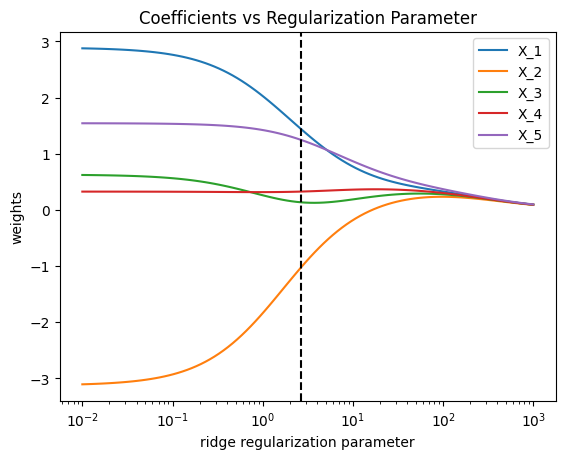

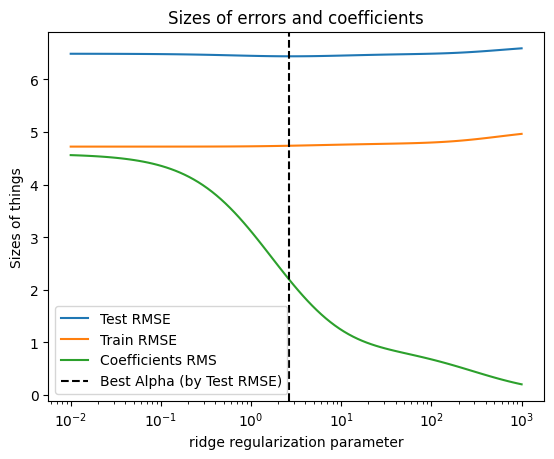

In [12]:
X = df.iloc[:, 0:5] #X_1 to X_5
Y_1 = df.iloc[:, 5] #Y_1
try_many_ridge_reg(X,Y_1)

# Y_2 using Ridge

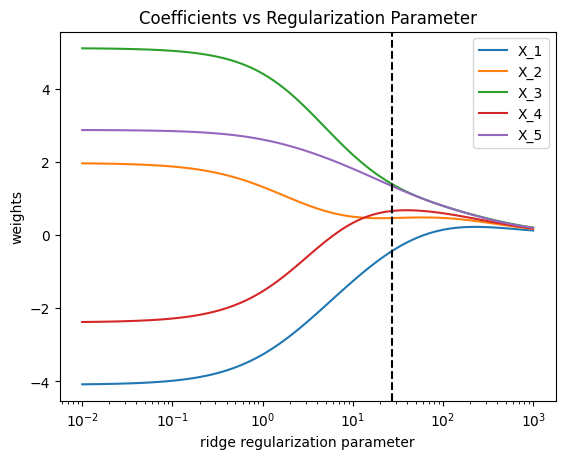

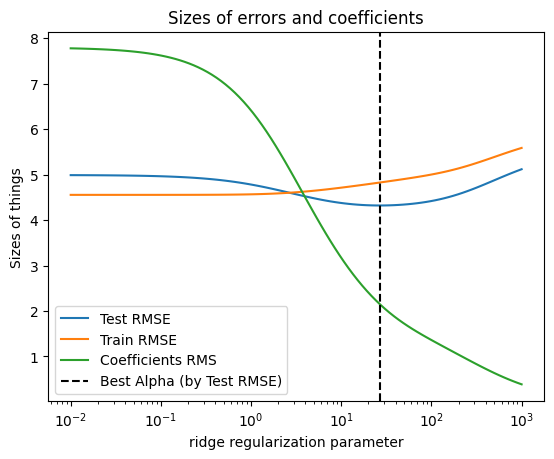

In [13]:
X = df.iloc[:, 0:5] #X_1 to X_5
Y_2 = df.iloc[:, 6] #Y_2
try_many_ridge_reg(X,Y_2)